In [2]:
#import metropolized_adaptive_nuts.step_size_adapt_NUTS_metropolized as nuts_b
import NUTSOrbitDiagnostic as nod
import numpy as np
import Fixed_step_size_NUTS_simulation as fv
import matplotlib.pyplot as plt
seed = 12909067
model = fv.create_model_stan_and_json("funnel", "funnel")
rng = np.random.default_rng(seed)

theta_log_sigma_initial = -2.0
velocity_log_sigma_component = -2.0
velocity_x_component = 1.0

theta_0 = np.empty(model.param_unc_num())
theta_0[0] = theta_log_sigma_initial
theta_0[1:] = 0

rho_0  = np.empty(model.param_unc_num())
rho_0[0] = velocity_log_sigma_component
rho_0[1:] = velocity_x_component

rho_0 = (rho_0 /np.linalg.norm(rho_0))*np.sqrt(11)

bernoulli_sequence = (1,)*10

sampler = nod.NUTSBprimeTransformDiagnostic(model,
                                             rng,
                                             theta_0,
                                             rho_0,
                                             0.7,
                                             1/4,
                                             10,
                                             10,
                                             nod.NUTSOrbitDiagnostic)
sampler.set_bernoulli_sequence(bernoulli_sequence)
theta, rho = sampler.draw()



ModuleNotFoundError: No module named 'NUTSOrbitDiagnostic'

In [3]:
unrefined_orbit = nod.NUTSOrbitDiagnostic(sampler,
                 rng,
                 theta_0,
                 rho_0,
                 max_stepsize,
                 1,
                 bernoulli_sequence,
                 tree_node_class=nod.NUTSTreeNodeDiagnostic)

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lf/7f0_cxm95fs6w7bm5w_mh5x80000gn/T/ipykernel_35811/1428230669.py:17: SyntaxWarning: invalid escape sequence '\l'


In [400]:
import matplotlib.pyplot as plt
import numpy as np

class OrbitPlotter:
    def __init__(self, orbit_root, contour_data=None):
        self.orbit_root = orbit_root
        self._leaf_counter = 0
        self._intermediate_counter = 0
        self._model = fv.create_model_stan_and_json("funnel", "funnel")
        self.x_lim = 9
        self.y_lim = 5
        if contour_data is None:
            self._contour_data = self.get_contour_data()
        else:
            self._contour_data = contour_data

        self.plotted_points = []
        self.plotted_points_indices = []
        self.energy_max = -np.inf
        self.energy_min = np.inf
        self.max_point = None
        self.min_point = None


        
        self.collect_plotted_points(orbit_root)
        self.find_energy_extrema()

    def set_energy_max_min(self, energy_max, energy_min):
        self.energy_max = energy_max
        self.energy_min = energy_min

    def reset_fig_ax(self):
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlabel("$\omega$")
        self.ax.set_ylabel("First $x$ coordinate")
        return 

    def log_joint(self, theta, rho):
        return self._model.log_density(theta) - .5 * np.dot(rho, rho)

    def get_contour_data(self):
        one_dim_model = fv.create_model_stan_and_json("funnel", "one_dimensional_funnel")
        x = np.linspace(-self.x_lim, self.x_lim, 1000)
        y = np.linspace(-self.y_lim, self.y_lim, 1000)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = one_dim_model.log_density(np.array([X[i, j], Y[i, j]]))
        contour_levels = np.percentile(Z, np.arange(0, 101, 17))
        return X, Y, Z, contour_levels

    def plot_contour(self):
        X, Y, Z, contour_levels = self._contour_data
        print(f"Contour levels: {contour_levels}")
        self.ax.contour(X, Y, Z,
                        levels=contour_levels,
                        colors='black',
                        linestyles='dotted',
                        linewidths=0.5,
                        alpha=1,
                        zorder=1)

    def calculate_size(self, energy):
        size = (1 + 40*(-energy + self.energy_max)/(self.energy_max - self.energy_min))
        return size

    def collect_plotted_points(self, orbit_root, index = ""):
        if orbit_root._height == 0:
            theta = orbit_root._left_theta
            rho = orbit_root._left_rho

            if -self.x_lim <= theta[0] <= self.x_lim and -self.y_lim <= theta[1] <= self.y_lim:
                self.plotted_points.append((theta, rho))
                self.plotted_points_indices.append(index)
            return

        if orbit_root._left_child is not None:
            self.collect_plotted_points(orbit_root._left_child, index = index + "0")

        if orbit_root._right_child is not None:
            self.collect_plotted_points(orbit_root._right_child, index = index + "1")

    def find_energy_extrema(self):
        for theta, rho in self.plotted_points:
            energy = -self.log_joint(theta, rho)
            if energy > self.energy_max:
                self.max_point = (theta, rho)
                self.energy_max = energy
                
            elif energy < self.energy_min:
                self.min_point = (theta, rho)
                self.energy_min = energy
        
    def plot_coarse(self):
        for theta, rho in self.plotted_points:
            energy = -self.log_joint(theta, rho)
            size = self.calculate_size(energy)
            self.ax.scatter(theta[0], theta[1], s=size, color='black')


    def plot_orbit_no_decoration(self):
        self.reset_fig_ax()
        self.plot_contour()
        self.plot_coarse()
        max_theta, max_rho = self.max_point
        min_theta, min_rho = self.min_point
        print(f"Max energy point = ({max_theta[0]}, {max_theta[1]})")
        print(f"Min energy point = ({min_theta[0]}, {min_theta[1]})")

    def plot_orbit_with_decoration(self, h_plus_marking_x, h_plus_marking_y, h_minus_marking_x, h_minus_marking_y, percentage):
        self.plot_orbit_no_decoration()
        max_theta, max_rho = self.max_point
        min_theta, min_rho = self.min_point

        energy_at_max = -self.log_joint(max_theta, max_rho)
        energy_at_min = -self.log_joint(min_theta, min_rho)
        
        label_offset = 0.5  # Offset for the text label from the point

        # Calculate position for H^+ label
        delta_x, delta_y = max_theta[0] - h_plus_marking_x, max_theta[1] - h_plus_marking_y
        self.ax.text(h_plus_marking_x, 
                     h_plus_marking_y, 
                     "$H^+$" + f" = {energy_at_max:.2f}",
                     zorder = 0,
                    fontsize = 10)
        
        self.ax.arrow(h_plus_marking_x + percentage * delta_x,
                      h_plus_marking_y + percentage * delta_y,
                      delta_x * (1 - 2 * percentage),
                      delta_y * (1 - 2 * percentage),
                      head_width=0.1, head_length=0.2, fc='black', ec='black')
        

        # Calculate position for H^- label
        delta_x, delta_y = min_theta[0] - h_minus_marking_x, min_theta[1] - h_minus_marking_y
        self.ax.text(h_minus_marking_x, 
                     h_minus_marking_y, 
                     "$H^-$" + f" = {energy_at_min: .2f}",
                     zorder = 0,
                    fontsize = 10)
        
        self.ax.arrow(h_minus_marking_x + percentage * delta_x,
                      h_minus_marking_y + percentage * delta_y,
                      delta_x * (1 - 2 * percentage),
                      delta_y * (1 - 2 * percentage),
                      head_width=0.1, head_length=0.2, fc='black', ec='black')

        
    def show(self):
        plt.show()

    def save_plot(self, filename):
        self.fig.savefig(filename)


<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
/var/folders/lf/7f0_cxm95fs6w7bm5w_mh5x80000gn/T/ipykernel_35811/3348361903.py:35: SyntaxWarning: invalid escape sequence '\l'


In [413]:
def obtain_orbit_with_step_size(theta_log_sigma_initial, 
                                velocity_log_sigma_component, 
                                velocity_x_component, 
                                max_step_size, 
                                halvings
                                ):

    seed = 12909067
    model = fv.create_model_stan_and_json("funnel", "funnel")
    rng = np.random.default_rng(seed)
    
    theta_0 = np.empty(model.param_unc_num())
    theta_0[0] = theta_log_sigma_initial
    theta_0[1:] = 0
    
    rho_0  = np.empty(model.param_unc_num())
    rho_0[0] = velocity_log_sigma_component
    rho_0[1:] = velocity_x_component
    
    rho_0 = (rho_0 /np.linalg.norm(rho_0))*np.sqrt(11)
    
    bernoulli_sequence = (1,)*10

    orbit = nod.NUTSOrbitDiagnostic(sampler,
                 rng,
                 theta_0,
                 rho_0,
                 max_step_size*2**(-halvings),
                 2**(halvings),
                 bernoulli_sequence,
                 tree_node_class=nod.NUTSTreeNodeDiagnostic)
    filename = f"LSig_{theta_log_sigma_initial}_vls_{velocity_log_sigma_component}_vx_{velocity_x_component}_maxh_{max_step_size}_halvings_{halvings}.png"
    return orbit, filename
    

In [414]:
orbits = [obtain_orbit_with_step_size(ls_init, -2.0, 1.0, 1/4, halvings) for ls_init in [-2.0, 2.0] for halvings in [0, 1, 2]]

/Users/milostevenmarsden/Documents/adaptive-hmc/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /Users/milostevenmarsden/Documents/adaptive-hmc/stan/funnel_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
/Users/milostevenmarsden/Documents/adaptive-hmc/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /Users/milostevenmarsden/Documents/adaptive-hmc/stan/funnel_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
/Users/milostevenmarsden/Documents/adaptive-hmc/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /Users/milostevenmarsden/Documents/adaptive-hmc/stan/funnel_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the libr

In [426]:
unrefined_orbit, unrefined_orbit_filename = orbits[0]
one_half_orbit, one_half_orbit_filename = orbits[1]
mouth_orbit, mouth_orbit_filename = orbits[3]

In [427]:
#UnrefinedOrbitPlotter = OrbitPlotter(unrefined_orbit._orbit_root)
#contour_data = UnrefinedOrbitPlotter._contour_data
UnrefinedOrbitPlotter = OrbitPlotter(unrefined_orbit._orbit_root, contour_data= contour_data)
OneHalfOrbitPlotter = OrbitPlotter(one_half_orbit._orbit_root, contour_data = contour_data)
MouthOrbitPlotter = OrbitPlotter(mouth_orbit._orbit_root, contour_data = contour_data)

/Users/milostevenmarsden/Documents/adaptive-hmc/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /Users/milostevenmarsden/Documents/adaptive-hmc/stan/funnel_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
/Users/milostevenmarsden/Documents/adaptive-hmc/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /Users/milostevenmarsden/Documents/adaptive-hmc/stan/funnel_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the library!
/Users/milostevenmarsden/Documents/adaptive-hmc/lib/python3.12/site-packages/bridgestan/model.py:140: UserWarning: Loading a shared object /Users/milostevenmarsden/Documents/adaptive-hmc/stan/funnel_model.so that has already been loaded.
If the file has changed since the last time it was loaded, this load may not update the libr

In [417]:
destination_directory = "/Users/milostevenmarsden/Documents/Simulations/July2024/Fixed_Orbit_Evolution/Labeled_with_arrows"

In [428]:
total_energy_max = max(instance.energy_max for instance in [UnrefinedOrbitPlotter, OneHalfOrbitPlotter, MouthOrbitPlotter])
total_energy_min = min(instance.energy_min for instance in [UnrefinedOrbitPlotter, OneHalfOrbitPlotter, MouthOrbitPlotter])

In [429]:
for instance in [UnrefinedOrbitPlotter, OneHalfOrbitPlotter, MouthOrbitPlotter]:
    instance.set_energy_max_min(total_energy_max, total_energy_min)

Contour levels: [-1.01288549e+05 -7.69482905e+02 -3.05553861e+01 -6.76155396e+00
 -3.85008071e+00 -2.07303830e+00]
Max energy point = (6.922627429186339, -2.5257249416582868)
Min energy point = (-3.695875549674923, -0.13171792347122535)


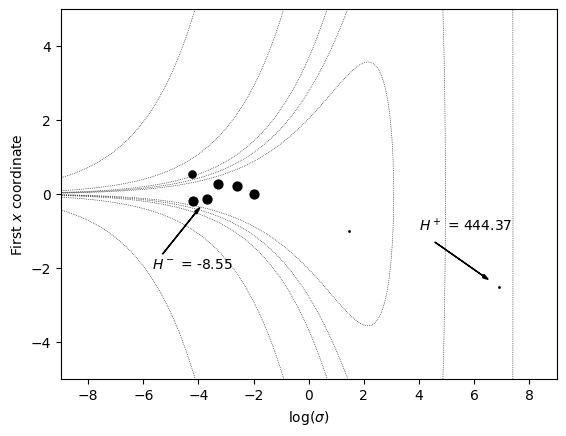

In [430]:
UnrefinedOrbitPlotter.plot_orbit_with_decoration(4.0, -1.0, -5.7, -2.0, .2)
#UnrefinedOrbitPlotter.save_plot(f"{destination_directory}/{unrefined_orbit_filename}")

Contour levels: [-1.01288549e+05 -7.69482905e+02 -3.05553861e+01 -6.76155396e+00
 -3.85008071e+00 -2.07303830e+00]
Max energy point = (-3.2685108703858172, 0.22829149312794958)
Min energy point = (-4.898031417876896, 0.08440014818031108)


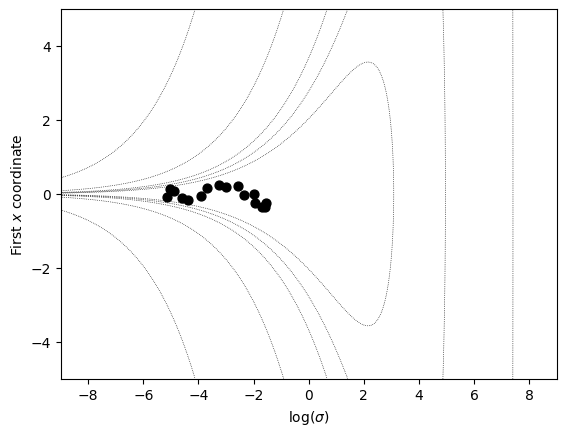

In [431]:
OneHalfOrbitPlotter.plot_orbit_no_decoration()

Contour levels: [-1.01288549e+05 -7.69482905e+02 -3.05553861e+01 -6.76155396e+00
 -3.85008071e+00 -2.07303830e+00]
Max energy point = (-3.2685108703858172, 0.22829149312794958)
Min energy point = (-4.898031417876896, 0.08440014818031108)


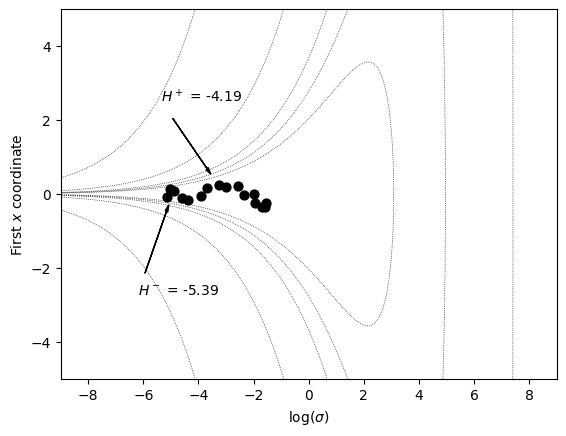

In [432]:
OneHalfOrbitPlotter.plot_orbit_with_decoration(-5.35, 2.5, -6.2, -2.7, .2)
#OneHalfOrbitPlotter.save_plot(f"{destination_directory}/{one_half_orbit_filename}")

Contour levels: [-1.01288549e+05 -7.69482905e+02 -3.05553861e+01 -6.76155396e+00
 -3.85008071e+00 -2.07303830e+00]
Max energy point = (-1.6538379149183833, -0.8277228970889903)
Min energy point = (-1.9422521575294533, 0.0016162598007767315)


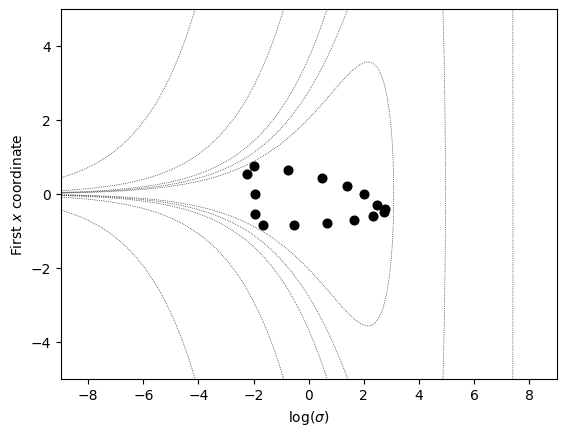

In [433]:
MouthOrbitPlotter.plot_orbit_no_decoration()

Contour levels: [-1.01288549e+05 -7.69482905e+02 -3.05553861e+01 -6.76155396e+00
 -3.85008071e+00 -2.07303830e+00]
Max energy point = (-1.6538379149183833, -0.8277228970889903)
Min energy point = (-1.9422521575294533, 0.0016162598007767315)


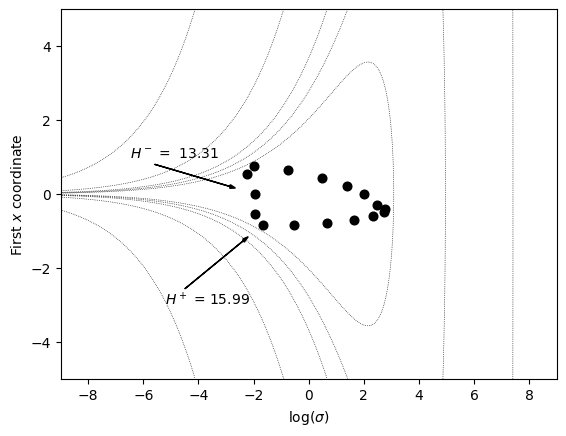

In [425]:
MouthOrbitPlotter.plot_orbit_with_decoration(-5.2, -3.0, -6.5, 1.0, .2)
MouthOrbitPlotter.save_plot(f"{destination_directory}/{mouth_orbit_filename}")

In [33]:
for orbit, filename in orbits:
    Plotter.reset_fig_ax()
    Plotter.plot_orbit(orbit._orbit_root)
    Plotter.save_plot(f"/Users/milostevenmarsden/Documents/Simulations/July2024/Fixed_Orbit_Evolution/Labeled/{filename}")

In [ ]:
class OrbitPlotter:
    def __init__(self, contour_data=None):

        #self.ax.grid(True)
        self._leaf_counter = 0
        self._intermediate_counter = 0
        self._model = fv.create_model_stan_and_json("funnel", "funnel")
        self.x_lim = 9
        self.y_lim = 5
        if contour_data is None:
            self._contour_data = self.get_contour_data()
        else:
            self._contour_data = contour_data

    def reset_fig_ax(self):
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlabel("$\omega$")
        self.ax.set_ylabel("First $x$ coordinate")
        return 
        
    def set_energy_max_min(self, energy_max, energy_min):
        self._energy_max = energy_max
        self._energy_min = energy_min
    
    def log_joint(self, theta, rho):
        return self._model.log_density(theta) - .5 * np.dot(rho, rho)

    def get_contour_data(self):
        one_dim_model = fv.create_model_stan_and_json("funnel", "one_dimensional_funnel")
        x = np.linspace(-self.x_lim, self.x_lim, 1000)
        y = np.linspace(-self.y_lim, self.y_lim, 1000)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = one_dim_model.log_density(np.array([X[i, j], Y[i, j]]))
        contour_levels = np.percentile(Z, np.arange(0, 101, 18))
        return X, Y, Z, contour_levels

    def plot_contour(self):
        X, Y, Z, contour_levels = self._contour_data
        print(f"Contour levels: {contour_levels}")
        self.ax.contour(X, Y, Z,
                        levels=contour_levels,
                        colors='black',
                        linestyles='dotted',
                        linewidths=0.7,
                        alpha=1,
                        zorder=1)
        #self.ax.set_xlim(self.x_lim)
        #self.ax.set_ylim(self.y_lim)

    def calculate_size(self, energy):
        size = (1 + 40*(-energy + self._energy_max)/(self._energy_max - self._energy_min))
        return size
        
        #return 2000/size

    def plot_coarse(self, orbit_root, index = ""):
        if orbit_root._height == 0:
            theta = orbit_root._left_theta
            rho = orbit_root._left_rho
            energy = -self.log_joint(theta, rho)
            size = self.calculate_size(energy)
            
            print(f"For index {int(index, 2)} the energy is {energy} and the size is {size}")
            print(f"The coordinates are ({theta[0]}, {theta[1]})")
            #size = 16
            #print(f"Theta Coordinates are: ({theta[0]}, {theta[1]})")
            #print(f"Rho Coordinates are: ({rho[0]}, {rho[1]})")
            
            if -self.x_lim <= theta[0] <= self.x_lim and -self.y_lim <= theta[1] <= self.y_lim:
                self.ax.scatter(theta[0], theta[1], s=size, color='black')
            self._leaf_counter += 1
            return

        if orbit_root._left_child is not None:
            self.plot_coarse(orbit_root._left_child, index = index + "0")

        if orbit_root._right_child is not None:
            self.plot_coarse(orbit_root._right_child, index = index + "1")

    def plot_fine(self, orbit_root):
        if orbit_root._height == 0:
            if orbit_root._intermediate_grid_points is not None:
                #print(f"Intermediate points: {orbit_root._intermediate_grid_points}")
                if len(orbit_root._intermediate_grid_points) > 0:
                    for index, (theta, rho) in enumerate(orbit_root._intermediate_grid_points):
                        self._intermediate_counter += 1
                        #print(f"Intermediate coordinates are: ({theta[0]}, {theta[1]})")
                        if len(theta) > 0 and len(rho) > 0:
                            if -self.x_lim <= theta[0] <= self.x_lim and -self.y_lim <= theta[1] <= self.y_lim:
                                #print(f"Theta is {theta}")
                                self.ax.scatter(theta[0], theta[1], s=8, color='black')
                return
            else:
                #print("Intermediate points is None")
                return

        if orbit_root._left_child is not None:
            self.plot_fine(orbit_root._left_child)

        if orbit_root._right_child is not None:
            self.plot_fine(orbit_root._right_child)

    def add_arrows(self, orbit_root):
        if orbit_root._height == 0:
            theta = orbit_root._left_theta
            rho = orbit_root._left_rho
            rho = .25*rho/np.sqrt(np.dot(rho, rho))
            self.ax.arrow(theta[0],
                              theta[1],
                              rho[0],
                              rho[1],
                              head_width=0.20,
                              head_length=0.25)
            return 
        if orbit_root._left_child is not None:
            self.add_arrows(orbit_root._left_child)

        if orbit_root._right_child is not None:
            self.add_arrows(orbit_root._right_child)
        

    def plot_orbit(self, orbit_root):
        self.reset_fig_ax()
        #self.set_energy_max_min(orbit_root._energy_max, orbit_root._energy_min)
        self.plot_contour()
        self.plot_coarse(orbit_root)
        #self.add_arrows(orbit_root)
        #self.plot_fine(orbit_root)

    def show(self):
        plt.show()

    def save_plot(self, filename):
        self.fig.savefig(filename)
